In [1]:
# import Data Manipulation Libraries
import pandas as pd
import numpy as np

# import Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import warning
import warnings
warnings.filterwarnings("ignore")

# import logging
import logging
logging.basicConfig(level=logging.INFO,
                    filename = "model.log",
                    filemode="w",
                    format= "%(asctime)s - %(levelname)s - %(message)s", force = True)

# Multicolinearity test and treatment libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,learning_curve,KFold
from sklearn.metrics import mean_squared_error,r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.cluster import KMeans

In [2]:
url  = "https://raw.githubusercontent.com/Frisk516/Insurance_MLModel/refs/heads/main/Insurance%20Dataset.csv"

df = pd.read_csv(url)
df.sample(frac=1)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
6445,6445,25.0,Male,7954.0,Single,2.0,Bachelor's,Self-Employed,26.382933,Urban,...,3.0,5,646.0,9,25-11-2020 15:21,Poor,No,Rarely,Apartment,2087
757,757,23.0,Female,35754.0,Single,1.0,High School,Employed,37.719063,Rural,...,1.0,13,721.0,9,11-12-2022 15:21,Average,Yes,Weekly,Condo,584
4571,4571,57.0,Male,38916.0,Divorced,3.0,Master's,Employed,45.082686,Suburban,...,1.0,2,491.0,3,22-12-2022 15:21,Poor,Yes,Monthly,Apartment,790
8650,8650,39.0,Male,127435.0,Married,0.0,Master's,Unemployed,27.292068,Suburban,...,0.0,10,384.0,7,26-08-2020 15:21,Good,No,Rarely,House,106
6244,6244,33.0,Male,43831.0,Divorced,3.0,Bachelor's,NaN,7.004079,Urban,...,1.0,15,604.0,7,24-09-2019 15:21,Average,No,Monthly,Apartment,1404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4502,4502,19.0,Female,3849.0,Single,3.0,PhD,Employed,21.750023,Rural,...,NaN,13,485.0,7,21-06-2024 15:21,Poor,Yes,Monthly,House,570
1108,1108,57.0,Female,43471.0,Single,NaN,PhD,Unemployed,20.244810,Suburban,...,NaN,15,444.0,2,14-09-2023 15:21,Poor,Yes,Rarely,Condo,838
2663,2663,51.0,Male,44879.0,Divorced,1.0,High School,Unemployed,20.552489,Rural,...,NaN,9,598.0,5,03-09-2021 15:21,Good,No,Monthly,Apartment,3172
5729,5729,42.0,Female,57226.0,Married,4.0,Bachelor's,NaN,14.672642,Urban,...,1.0,11,310.0,1,07-09-2020 15:21,Average,No,Weekly,House,2211


In [3]:
df.isnull().sum()

id                         0
Age                      143
Gender                     0
Annual Income            384
Marital Status           157
Number of Dependents     928
Education Level            0
Occupation              2878
Health Score             601
Location                   0
Policy Type                0
Previous Claims         3011
Vehicle Age                0
Credit Score            1186
Insurance Duration         0
Policy Start Date          0
Customer Feedback        713
Smoking Status             0
Exercise Frequency         0
Property Type              0
Premium Amount             0
dtype: int64

In [4]:
df.drop(["Age", "Annual Income", "Marital Status", "Number of Dependents", "Occupation", "Health Score", "Previous Claims", "Credit Score", "Customer Feedback"], axis= 1, inplace=True)

In [5]:
df["Insurance Duration"].fillna(df["Insurance Duration"].median(), inplace=True)
df["Vehicle Age"].fillna(df["Vehicle Age"].median(), inplace=True)

In [6]:
df.isnull().sum()

id                    0
Gender                0
Education Level       0
Location              0
Policy Type           0
Vehicle Age           0
Insurance Duration    0
Policy Start Date     0
Smoking Status        0
Exercise Frequency    0
Property Type         0
Premium Amount        0
dtype: int64

<Axes: >

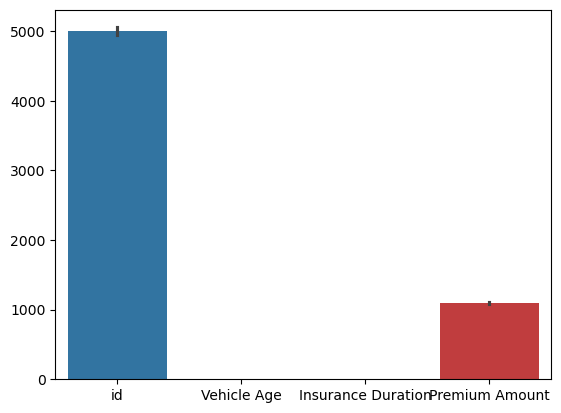

In [7]:
sns.barplot(data=df)



In [8]:
from collections import OrderedDict

stats = []

for col in df.columns :
    if df[col].dtype != "object" and df[col].dtype != "bool":
        numerical_stats =  OrderedDict({
            "Feature" : col,
            "Min"  : df[col].min(),
            "Max" : df[col].max(),
            "mean" : df[col].mean(),
            "median" : df[col].median(),
            "mode" : df[col].mode()[0] if not df[col].mode().empty else None,
            "25%": df[col].quantile(0.25),
            "75%" : df[col].quantile(0.75),
            "Skewness" : df[col].skew(),
            "Kurtosis" : df[col].kurt()           
        })
        stats.append(numerical_stats)

# Convert to DataFrame
report = pd.DataFrame(stats)

# Outlier Identification :
outlier_label = []
for col in report['Feature']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    LW = Q1 - 1.5 * IQR   # LW : Lower Whisker Line
    UW = Q3 + 1.5 * IQR   # UW : Upper Whisker Line
    outliers = df[(df[col] < LW) | (df[col] > UW)]
    if not outliers.empty:
        outlier_label.append("Has Outliers")
    else:
        outlier_label.append("No Outliers")

report["Outlier Comment"] = outlier_label

# Checking Report
report
    

,Feature,Min,Max,mean,median,mode,25%,75%,Skewness,Kurtosis,Outlier Comment
0,id,0,9999,4999.5000,4999.5,0,2499.75,7499.25,0.000000,-1.200000,No Outliers
1,Vehicle Age,0,19,9.5773,10.0,14,4.00,15.00,-0.022922,-1.229473,No Outliers
2,Insurance Duration,1,9,5.0073,5.0,1,3.00,7.00,-0.004976,-1.246382,No Outliers
3,Premium Amount,20,4974,1099.7576,872.0,23,511.00,1511.00,1.243543,1.497307,Has Outliers


In [9]:
# Replace Outliers with Median Statergy

for col in df.select_dtypes(include='number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_count = outliers.sum()

    if outlier_count > 0:
        replacement = df[col].median()  
        df.loc[outliers, col] = replacement
        print(f"Replaced {outlier_count} outliers in '{col}' with median.")
    else:
        print(f"No outliers found in '{col}'.")

No outliers found in 'id'.
No outliers found in 'Vehicle Age'.
No outliers found in 'Insurance Duration'.
Replaced 423 outliers in 'Premium Amount' with median.


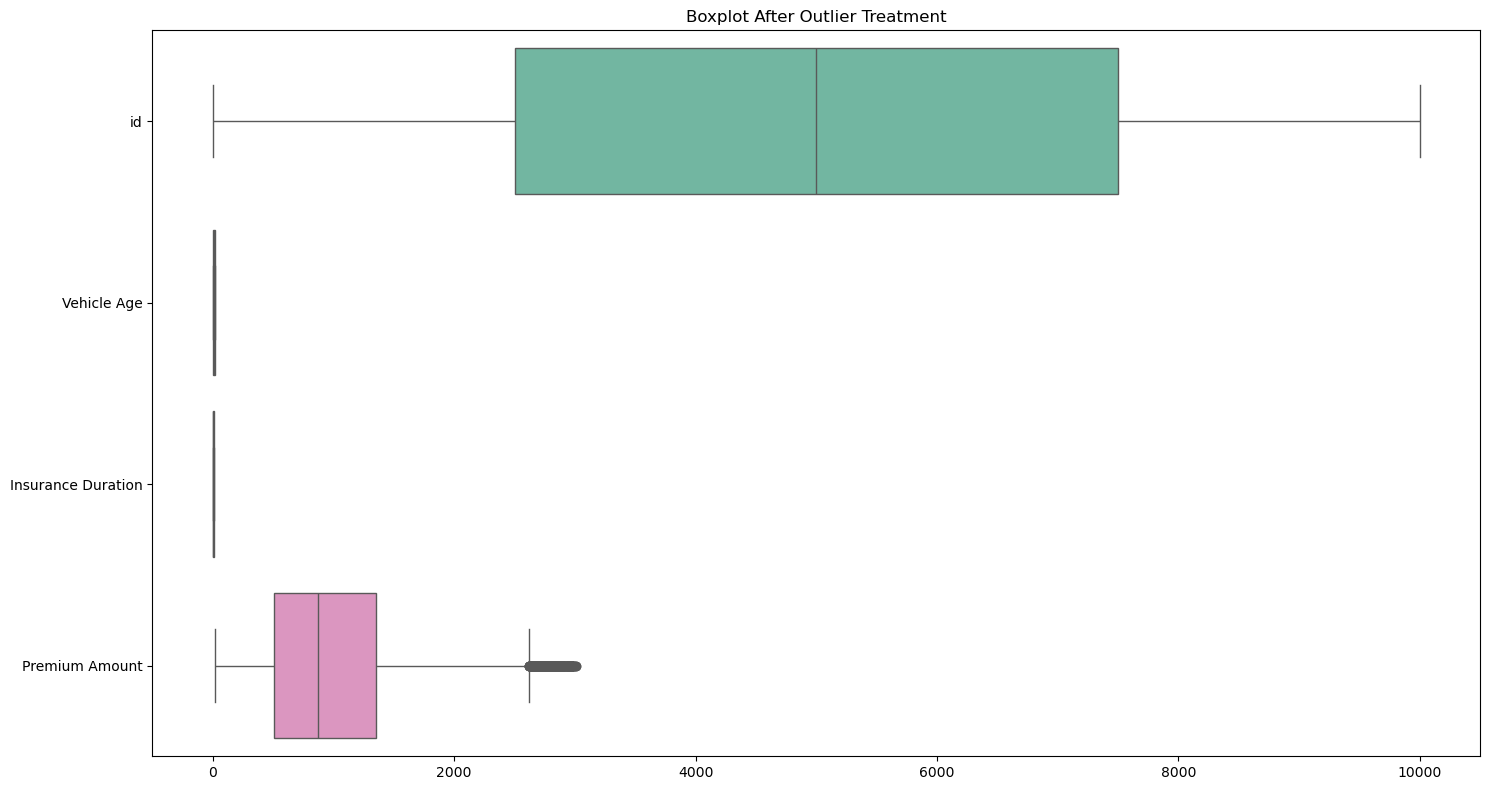

In [10]:
# Set figure size
plt.figure(figsize=(15, 8))

# Create boxplot for all numerical columns
sns.boxplot(data=df, orient='h', palette='Set2')

# Set title
plt.title('Boxplot After Outlier Treatment')
plt.tight_layout()
plt.show()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  10000 non-null  int64 
 1   Gender              10000 non-null  object
 2   Education Level     10000 non-null  object
 3   Location            10000 non-null  object
 4   Policy Type         10000 non-null  object
 5   Vehicle Age         10000 non-null  int64 
 6   Insurance Duration  10000 non-null  int64 
 7   Policy Start Date   10000 non-null  object
 8   Smoking Status      10000 non-null  object
 9   Exercise Frequency  10000 non-null  object
 10  Property Type       10000 non-null  object
 11  Premium Amount      10000 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 937.6+ KB


In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])
df["Education Level"] = le.fit_transform(df["Education Level"])
df["Location"] = le.fit_transform(df["Location"])
df["Policy Type"] = le.fit_transform(df["Policy Type"])
df["Policy Start Date"] = le.fit_transform(df["Policy Start Date"])
df["Smoking Status"] = le.fit_transform(df["Smoking Status"])
df["Exercise Frequency"] = le.fit_transform(df["Exercise Frequency"])
df["Property Type"] = le.fit_transform(df["Property Type"])

In [13]:

# Checking VIF:
def calculate_vif(dataset):
    vif = pd.DataFrame()
    vif['features'] = dataset.columns
    vif['VIF_Values'] = [variance_inflation_factor(dataset.values,i) for i in range(dataset.shape[1])]
    vif['VIF_Values'] = round(vif['VIF_Values'], 2)
    vif = vif.sort_values(by = 'VIF_Values', ascending=False)
    return (vif)

calculate_vif(df.drop("Insurance Duration",axis = 1))

,features,VIF_Values
6,Policy Start Date,3.47
0,id,3.46
5,Vehicle Age,3.25
10,Premium Amount,2.78
8,Exercise Frequency,2.62
2,Education Level,2.56
4,Policy Type,2.40
9,Property Type,2.31
3,Location,2.30
1,Gender,1.95


In [14]:
df.corr()["Premium Amount"]

id                   -0.010963
Gender                0.001515
Education Level       0.003966
Location             -0.010235
Policy Type           0.004520
Vehicle Age          -0.001496
Insurance Duration   -0.010619
Policy Start Date     0.013457
Smoking Status       -0.011068
Exercise Frequency    0.000626
Property Type        -0.014655
Premium Amount        1.000000
Name: Premium Amount, dtype: float64

In [15]:
# Using PCA Concept:

# Step 1: Standardize the data

scaler = RobustScaler()
X_scaled = scaler.fit_transform(df)

# Step 2: Determine number of components to retain 90% variance

for i in range(1, df.shape[1] + 1):
    pca = PCA(n_components=i)
    pca.fit(X_scaled)
    evr = np.cumsum(pca.explained_variance_ratio_)
    if evr[i - 1] >= 0.90:
        pcs = i
        break

print("Explained Variance Ratio:", evr)
print("Number of components selected:", pcs)

# Step 3: Apply PCA

pca = PCA(n_components=pcs)
pca_data = pca.fit_transform(X_scaled)

# Step 4: Create DataFrame

pca_columns = [f'PC{j+1}' for j in range(pcs)]
pca_df = pd.DataFrame(pca_data, columns=pca_columns)

# Step 5: Join Target Column with PCA:

pca_df = pca_df.join(df["Premium Amount"], how = 'left')

pca_df

Explained Variance Ratio: [0.18975954 0.31169789 0.40849238 0.50365384 0.59417853 0.67413778
 0.74586958 0.81684381 0.86532981 0.91313232]
Number of components selected: 10


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Premium Amount
0,2.253807,-0.001875,0.849124,-0.754796,0.551669,0.822113,-0.285537,-0.601893,0.213271,0.521984,2869
1,0.609580,-0.792762,0.192591,-0.916603,-0.475841,0.073898,-0.675117,0.163059,0.691529,-0.071626,1483
2,-0.459450,-0.516432,1.310836,-0.481780,0.605928,0.451419,-0.026121,0.759034,0.472253,0.481432,567
3,-0.225295,-1.070077,0.310683,-0.769583,-0.844663,-0.981419,0.335528,0.625413,-0.234222,-0.530022,765
4,1.225595,-0.229305,-0.330960,-1.402309,0.529006,-0.190635,0.111599,0.728280,0.676859,0.420805,2022
...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.351058,-0.958286,-0.115680,0.957903,0.887023,-0.162575,-0.710221,0.112502,-0.221223,-0.641757,675
9996,-0.324351,0.328589,-0.729494,0.667767,0.301583,0.396641,0.045912,0.733799,-0.219768,-0.645756,736
9997,-1.069271,-0.961587,-0.975469,0.473658,0.823859,0.227014,-0.775173,0.145242,0.127453,0.034108,100
9998,-0.648817,0.007174,-1.055493,0.640940,-0.677991,-0.259006,-0.610904,0.065143,-0.266443,-0.608726,464


In [16]:
X = pca_df.drop(["Premium Amount"], axis= 1)
y = np.log(pca_df["Premium Amount"])

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.20, random_state=42)

In [17]:
scaler = RobustScaler()
X_train  = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# Model Building

def train_and_test_split(data, tcol, testSize=0.3, randomState=3):
    X = data.drop(tcol,axis=1)
    y = np.log(data[tcol])
    return train_test_split(X,y,test_size = testSize,random_state=randomState)

def model_builder(model_name, model, data, t_col):
    X_train,X_test,y_train,y_test = train_and_test_split(data,t_col)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    result = [model_name, rmse, r2]
    return result

model_builder(model_name='SVR',model=SVR(),data=pca_df,t_col="Premium Amount")

['SVR', 0.24112977435660587, 0.9478813884859814]